# Proyecto: Técnicas para prevenir error de "Overfitting"


## En el presente proyecto se muestra un problema de clasificación binaria con redes neuronales donde la capa de salida tiene una sola neurona,

## por lo que la función de activación en la capa de salida es del tipo `activation = sigmoid` y la función de costo es del tipo `loss = binary_crossentropy`

## Haremos "Overfitting" intencionalmente, posteriormente revisaremos técnicas para eliminarlo mediante:

## * Regularización (con normas $L_{1}$ y $L_{2}$)

## * DropOut (reducción del porcentaje de neuronas a activar en cada capa)

## Trabajaremos con el dataset "imdb" de Keras que corresponde a reseñas (comentarios) que son de 2 clases distintas: buenos ó malos (clasificación binaria)

In [1]:
import numpy as np

# importamos funciones para construir redes neuronales:
from tensorflow.keras import layers, models, optimizers, regularizers

# importamos dataset:
from keras.datasets import imdb

# Librería para separar datos:
from sklearn.model_selection import train_test_split

# función para codificar variables
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt


In [2]:
# Cargamos datos:

# Maximo numero de palabras en cada mensaje
N = 10000

(features_train , labels_train),(features_test , labels_test) = imdb.load_data(num_words=N)

# Diccionario {'palabra':numero} correspondiente al dataset 'reuters'
dict_word_index = imdb.get_word_index()

# Los 'features' son arreglos cuyos elementos son listas de la forma:
# feature[i] = [n0,n1,...,nk] donde cada número 'ni' corresponde a una palabla
# cuyo valor se decodifica con el diccionario 'dict_word_index'.
# Así que cada lista 'feature[i]' representa un comentario.
#  
# El valor de cada 'label' es un número entero entre 0 y 45, que representa alguna de las
# 46 clasificaciones que puede tomar el 'feature' (comentario) correspondiente.

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/marck/.local/lib/python3.8/site-packages/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/marck/.local/lib/python3.8/site-packages/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specif

## Exploramos los datos:

In [3]:
# Exploramos datos:

print('El dataset "features_train" es de tamaño:' , features_train.shape)
print('El dataset "features_test" es de tamaño:' , features_test.shape)
print('Cada elemento de "features" es de tipo:' , type(features_train[0]))

print('\nEl dataset "labels_train" es de tamaño:' , labels_train.shape)
print('El dataset "labels_test" es de tamaño:' , labels_test.shape)
print('Cada elemento de "labels" es de tipo:' , type(labels_train[0]))

El dataset "features_train" es de tamaño: (25000,)
El dataset "features_test" es de tamaño: (25000,)
Cada elemento de "features" es de tipo: <class 'list'>

El dataset "labels_train" es de tamaño: (25000,)
El dataset "labels_test" es de tamaño: (25000,)
Cada elemento de "labels" es de tipo: <class 'numpy.int64'>


### De la información anterior podemos saber que cada "feature" es una lista (correspondiente a la codificación numérica de un mensaje)
### cada "label" es un numero entero del tipo: `numpy.int64`

In [4]:
# Si queremos ver el contenido de un mensaje debemos decodificarlo con el diccionario 'get_word_index()'
# como se mestra a continuación:

# seleccionmos un mensaje (k < 25000)
k = 15

numeric_message = features_train[k] # <--- k-esimo mensaje codificado con números

# Cambiamos el diccionario a la forma {numero:'palabra'}:
dict_index_word = dict( [ (value,key) for key,value in dict_word_index.items() ] )

# Decodificamos el k-esimo mensaje:
#for n in numeric_message:
#    # decodificamos el contenido usando el diccionario 'word_index':
#    print( dict_index_word.get(n-3) )

In [5]:
# Extraemos las clases totales de las etiquetas del dataset:
clases = np.unique(labels_train)
n_clases = len(clases)

print('Hay',n_clases,'clases posibles para las etiquetas')
print('Clases:\n',clases)

Hay 2 clases posibles para las etiquetas
Clases:
 [0 1]


## Codificamos features y labels para entrenar la red:

In [6]:
# A continuación creamos una funcón para codificar 
# los features como arreglos con entradas son binarias 

# Por ejemplo, 
# si 'feature' = [0,2,4] enconces,
# 'enoded_feature' = [1,0,1,0,1,0,0,0,0,...,0]
# 'enoded_feature' tiene '1' solamente en los índices dados en 'feature'

# Función que codifica los features con entradas binarias:
def features_encoder(features, dim=N):
    n_sentense = len(features)

    # Inicializamos arreglo con ceros:
    binary_features = np.zeros( (n_sentense, dim) )
    
    for i in range(n_sentense):
        for j in features[i]:
            # Vamos poniendo unos en los indices que indica 'features[i]'
            binary_features[i,j]=1
                
    return binary_features

In [7]:
# Aplicamos nuestra función para codificar los features:
x_train = features_encoder(features_train,dim=N)
x_test = features_encoder(features_test,dim=N)

In [8]:
# No codificaremos los labels, pues minimizaremos con 'binary_crossentropy'
# sin embargo pasaremos los valores al tipo array con valores 'float32'
y_train = np.asarray(labels_train).astype('float32')
y_test = np.asarray(labels_test).astype('float32')

In [9]:
# Particionamos el conjunto de entrenamiento original 
# en nuevos subconjuntos de entrenamiento y validación:

# Para provocar overfitting intencionalmentes generamos más datos de validación que de entrenamiento
p_train=0.4  # porcentaje para datos de entrenamiento
p_validation=0.6 # porcentaje  para datos de validación

x_train_part, x_validation, y_train_part, y_validation = train_test_split (x_train, y_train, train_size=p_train, test_size=p_validation, random_state=42)

print('Hay',len(x_train_part),'datos para entrenamiento y',len(x_validation),'datos para validación')

Hay 10000 datos para entrenamiento y 15000 datos para validación


In [10]:
# dimensión de los features para entrenar la red:
dim_feature = x_train_part[0].shape
dim_feature

(10000,)

# Pruebas con red neuronal 1: Red compleja (muchas conexiones)

In [11]:
# Creamos red neuronal 1:

nn1 = 16 # <-- numero de neuronas para la capa 1
nn2 = 16  # <-- numero de neuronas de la capa 2
nn3 = 1  # <-- numero de neuronas de la capa 3

n_epochs = 20
n_batch_size = 512

# INICIALIZAMOS RED
model1 = models.Sequential() # <-- se inicializa la red

# Se van agregando las capas con sus parámetros:
model1.add( layers.Dense(nn1 ,activation='relu', input_shape =dim_feature) )# <-- capa 1 (Recibe features)
model1.add( layers.Dense(nn2, activation='relu') ) # <-- capa 2
model1.add( layers.Dense(nn3, activation='sigmoid') )#<-- capa de salida (Arroja labels predichos)

In [12]:
# visualzamos la arquitecura de la red:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [13]:
# optimizador:
nadam = optimizers.Nadam(learning_rate=0.001)

# compilamos la red:
model1.compile(
    optimizer= nadam, # <--- Elegimos el método de optmimización,
    loss='binary_crossentropy',# <-- función de costo recomendada para clasificación binaria
    metrics='accuracy'
    )

In [14]:
# Entrenemos el modelo:
results1 = model1.fit(
    x_train_part, 
    y_train_part,
    epochs=n_epochs,
    batch_size=n_batch_size,
    validation_data=(x_validation , y_validation) # <-- agregamos datos para validación
    )

Epoch 1/20
20/20 [==============================] - 2s 67ms/step - loss: 0.6232 - accuracy: 0.6509 - val_loss: 0.5176 - val_accuracy: 0.8057
Epoch 2/20
20/20 [==============================] - 1s 37ms/step - loss: 0.4147 - accuracy: 0.8790 - val_loss: 0.3743 - val_accuracy: 0.8611
Epoch 3/20
20/20 [==============================] - 1s 40ms/step - loss: 0.2662 - accuracy: 0.9250 - val_loss: 0.3161 - val_accuracy: 0.8780
Epoch 4/20
20/20 [==============================] - 1s 39ms/step - loss: 0.1855 - accuracy: 0.9490 - val_loss: 0.2982 - val_accuracy: 0.8794
Epoch 5/20
20/20 [==============================] - 1s 35ms/step - loss: 0.1371 - accuracy: 0.9652 - val_loss: 0.3054 - val_accuracy: 0.8745
Epoch 6/20
20/20 [==============================] - 1s 34ms/step - loss: 0.1031 - accuracy: 0.9765 - val_loss: 0.3163 - val_accuracy: 0.8729
Epoch 7/20
20/20 [==============================] - 1s 36ms/step - loss: 0.0775 - accuracy: 0.9854 - val_loss: 0.3450 - val_accuracy: 0.8679
Epoch 8/20
20

<Figure size 432x288 with 0 Axes>

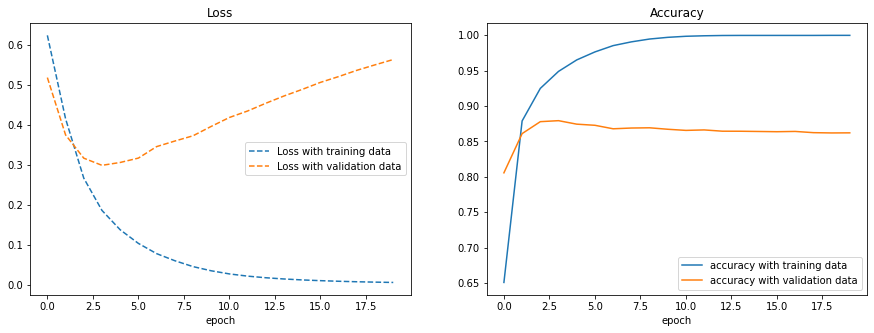

In [15]:
# visualizamos resultados:

history_dict = results1.history  # <-- extrae en 'accuracy' y 'loss' de cada 'epoch'
# history_dict = {'loss':[...], 'accuracy':[...], 'val_loss':[...], 'val_accuracy':[...] }

# Extraemos los valores de 'loss' y 'accuracy' obtenido en cada 'epoch':

loss_values_data_train = history_dict['loss']# <-- valores del 'loss' con datos de entrenamiento
loss_values_data_valid = history_dict['val_loss'] #<--valores del 'loss' con datos de validación
accuracy_values_data_train = history_dict['accuracy']# <-- valores del 'accuracy' con datos de entrenamiento
accuracy_values_data_valid = history_dict['val_accuracy'] # <-- valores del 'accuracy' con datos de validación

# numeramos 'epochs' contando desde 1:
epoch = range(n_epochs)

plt.figure()
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(epoch, loss_values_data_train, '--', label='Loss with training data')
plt.plot(epoch, loss_values_data_valid, '--', label='Loss with validation data')
plt.legend()
plt.title('Loss')
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy_values_data_train, label='accuracy with training data')
plt.plot(epoch, accuracy_values_data_valid, label='accuracy with validation data')
plt.legend()
plt.title('Accuracy')
plt.xlabel('epoch')

plt.show()

### En la grafica anterior se puede observar overfitting:
### 'Loss' pequeño con los datos de entrenamiento y 'Loss' grande con los datos de validación,
### es decir: El modelo memorizó pero no aprendió

In [16]:
# medimos precisión del entrenamiento con los datos de prueba:
model1.evaluate(x_test,y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.5764 - accuracy: 0.8549


[0.5763525366783142, 0.8548799753189087]

# Pruebas con red neuronal 2: Red menos compleja (pocas conexiones)

In [17]:
# Creamos red neuronal 2:

nn1 = 4 # <-- numero de neuronas para la capa 1
nn2 = 4  # <-- numero de neuronas de la capa 2
nn3 = 1  # <-- numero de neuronas de la capa 3

n_epochs = 20
n_batch_size = 512

# INICIALIZAMOS RED
model2 = models.Sequential() # <-- se inicializa la red

# Se van agregando las capas con sus parámetros:
model2.add( layers.Dense(nn1 ,activation='relu', input_shape = dim_feature) )# <-- capa 1 (Recibe features)
model2.add( layers.Dense(nn2, activation='relu') ) # <-- capa 2
model2.add( layers.Dense(nn3, activation='sigmoid') )#<-- capa de salida (Arroja labels predichos)

In [18]:
# visualzamos la arquitecura de la red:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [19]:
# optimizador:
nadam = optimizers.Nadam(learning_rate=0.001)

# compilamos la red:
model2.compile(
    optimizer= nadam, # <--- Elegimos el método de optmimización,
    loss='binary_crossentropy',# <-- función de costo recomendada para clasificación no binaria
    metrics='accuracy'
    )

In [20]:
# Entrenemos el modelo:
results2 = model2.fit(
    x_train_part, 
    y_train_part,
    epochs=n_epochs,
    batch_size=n_batch_size,
    validation_data=(x_validation , y_validation))

Epoch 1/20
20/20 [==============================] - 2s 57ms/step - loss: 0.6643 - accuracy: 0.6333 - val_loss: 0.6194 - val_accuracy: 0.7335
Epoch 2/20
20/20 [==============================] - 1s 30ms/step - loss: 0.5691 - accuracy: 0.8100 - val_loss: 0.5376 - val_accuracy: 0.7702
Epoch 3/20
20/20 [==============================] - 1s 30ms/step - loss: 0.4591 - accuracy: 0.8846 - val_loss: 0.4445 - val_accuracy: 0.8585
Epoch 4/20
20/20 [==============================] - 1s 29ms/step - loss: 0.3656 - accuracy: 0.9170 - val_loss: 0.3849 - val_accuracy: 0.8731
Epoch 5/20
20/20 [==============================] - 1s 31ms/step - loss: 0.2989 - accuracy: 0.9331 - val_loss: 0.3504 - val_accuracy: 0.8733
Epoch 6/20
20/20 [==============================] - 1s 29ms/step - loss: 0.2514 - accuracy: 0.9426 - val_loss: 0.3265 - val_accuracy: 0.8799
Epoch 7/20
20/20 [==============================] - 1s 29ms/step - loss: 0.2154 - accuracy: 0.9510 - val_loss: 0.3125 - val_accuracy: 0.8790
Epoch 8/20
20

<Figure size 432x288 with 0 Axes>

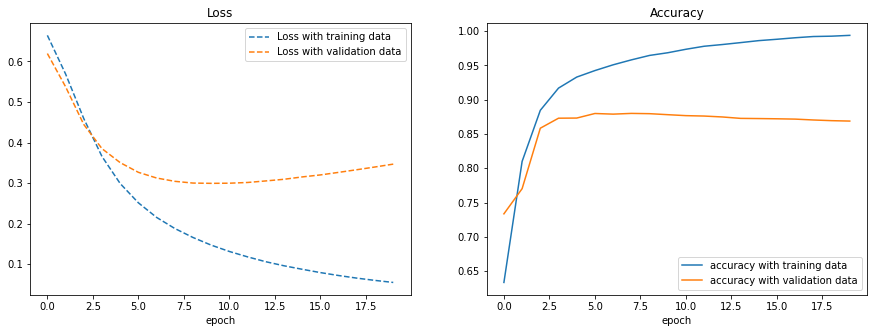

In [21]:
# visualizamos resultados:

history_dict = results2.history  # <-- extrae en 'accuracy' y 'loss' de cada 'epoch'
# history_dict = {'loss':[...], 'accuracy':[...], 'val_loss':[...], 'val_accuracy':[...] }

# Extraemos los valores de 'loss' y 'accuracy' obtenido en cada 'epoch':

loss_values_data_train = history_dict['loss']# <-- valores del 'loss' con datos de entrenamiento
loss_values_data_valid = history_dict['val_loss'] #<--valores del 'loss' con datos de validación
accuracy_values_data_train = history_dict['accuracy']# <-- valores del 'accuracy' con datos de entrenamiento
accuracy_values_data_valid = history_dict['val_accuracy'] # <-- valores del 'accuracy' con datos de validación

# numeramos 'epochs' contando desde 1:
epoch = range(n_epochs)

plt.figure()
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(epoch, loss_values_data_train, '--', label='Loss with training data')
plt.plot(epoch, loss_values_data_valid, '--', label='Loss with validation data')
plt.legend()
plt.title('Loss')
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy_values_data_train, label='accuracy with training data')
plt.plot(epoch, accuracy_values_data_valid, label='accuracy with validation data')
plt.legend()
plt.title('Accuracy')
plt.xlabel('epoch')

plt.show()

### En la grafica anterior se puede observar overfitting:
### 'Loss' pequeño con los datos de entrenamiento y 'Loss' grande con los datos de validación

In [22]:
# medimos precisión del entrenamiento con los datos de prueba:
model2.evaluate(x_test,y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.3580 - accuracy: 0.8668


[0.35795465111732483, 0.8668000102043152]

# Pruebas con red neuronal 3: Red menos compleja (pocas conexiones) + Regularizadores L1-L2

In [23]:
# Creamos red neuronal 3:

nn1 = 4 # <-- numero de neuronas para la capa 1
nn2 = 4  # <-- numero de neuronas de la capa 2
nn3 = 1  # <-- numero de neuronas de la capa 3

n_epochs = 20
n_batch_size = 512

alfa_l1 = 0.001 # <-- multiplo del regularizador l1
alfa_l2 = 0.001 # <-- multiplo del regularizador l2


# INICIALIZAMOS RED
model3 = models.Sequential() # <-- se inicializa la red

# Se van agregando las capas con sus parámetros:
model3.add( layers.Dense(nn1 ,activation='relu', input_shape =dim_feature, kernel_regularizer=regularizers.l1_l2(alfa_l1, alfa_l2)) )# <-- capa 1 (Recibe features) y hemos agregado regularizador
model3.add( layers.Dense(nn2, activation='relu', kernel_regularizer=regularizers.l1_l2(alfa_l1, alfa_l2)) ) # <-- capa 2 con regularizado
model3.add( layers.Dense(nn3, activation='sigmoid') )#<-- capa de salida (Arroja labels predichos)

In [24]:
# visualzamos la arquitecura de la red:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [25]:
# optimizador:
nadam = optimizers.Nadam(learning_rate=0.001)

# compilamos el modelo:
model3.compile(
    optimizer= nadam, # <--- Elegimos el método de optmimización,
    loss='binary_crossentropy',# <-- función de costo recomendada para clasificación no binaria
    metrics='accuracy'
    )

In [26]:
# Entrenemos el modelo:
results3 = model3.fit(
    x_train_part, 
    y_train_part,
    epochs=n_epochs,
    batch_size=n_batch_size,
    validation_data=(x_validation , y_validation))

Epoch 1/20
20/20 [==============================] - 2s 60ms/step - loss: 0.9496 - accuracy: 0.6740 - val_loss: 0.7227 - val_accuracy: 0.7776
Epoch 2/20
20/20 [==============================] - 1s 33ms/step - loss: 0.6401 - accuracy: 0.8237 - val_loss: 0.6014 - val_accuracy: 0.8250
Epoch 3/20
20/20 [==============================] - 1s 35ms/step - loss: 0.5679 - accuracy: 0.8528 - val_loss: 0.5594 - val_accuracy: 0.8325
Epoch 4/20
20/20 [==============================] - 1s 34ms/step - loss: 0.5262 - accuracy: 0.8638 - val_loss: 0.5256 - val_accuracy: 0.8472
Epoch 5/20
20/20 [==============================] - 1s 38ms/step - loss: 0.4947 - accuracy: 0.8748 - val_loss: 0.5017 - val_accuracy: 0.8547
Epoch 6/20
20/20 [==============================] - 1s 39ms/step - loss: 0.4706 - accuracy: 0.8804 - val_loss: 0.4858 - val_accuracy: 0.8558
Epoch 7/20
20/20 [==============================] - 1s 40ms/step - loss: 0.4528 - accuracy: 0.8831 - val_loss: 0.4729 - val_accuracy: 0.8590
Epoch 8/20
20

<Figure size 432x288 with 0 Axes>

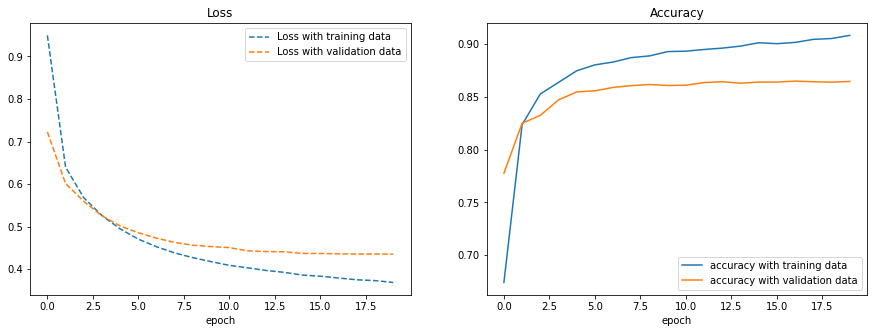

In [27]:
# visualizamos resultados:

history_dict = results3.history  # <-- extrae en 'accuracy' y 'loss' de cada 'epoch'
# history_dict = {'loss':[...], 'accuracy':[...], 'val_loss':[...], 'val_accuracy':[...] }

# Extraemos los valores de 'loss' y 'accuracy' obtenido en cada 'epoch':

loss_values_data_train = history_dict['loss']# <-- valores del 'loss' con datos de entrenamiento
loss_values_data_valid = history_dict['val_loss'] #<--valores del 'loss' con datos de validación
accuracy_values_data_train = history_dict['accuracy']# <-- valores del 'accuracy' con datos de entrenamiento
accuracy_values_data_valid = history_dict['val_accuracy'] # <-- valores del 'accuracy' con datos de validación

# numeramos 'epochs' contando desde 1:
epoch = range(n_epochs)

plt.figure()
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(epoch, loss_values_data_train, '--', label='Loss with training data')
plt.plot(epoch, loss_values_data_valid, '--', label='Loss with validation data')
plt.legend()
plt.title('Loss')
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy_values_data_train, label='accuracy with training data')
plt.plot(epoch, accuracy_values_data_valid, label='accuracy with validation data')
plt.legend()
plt.title('Accuracy')
plt.xlabel('epoch')

plt.show()


### En la grafica anterior se puede observar que hemos reducido el overfitting:
### 'Loss' pequeño con los datos de entrenamiento y 'Loss' pequeño con los datos de validación

In [28]:
# medimos precisión del entrenamiento con los datos de prueba:
model3.evaluate(x_test,y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.4328 - accuracy: 0.8660


[0.43277910351753235, 0.8660399913787842]

# Pruebas con red neuronal 4: Red menos compleja (pocas conexiones) + Dropout

In [29]:
# Creamos red neuronal 4:

nn1 = 4 # <-- numero de neuronas para la capa 1
nn2 = 4  # <-- numero de neuronas de la capa 2
nn3 = 1  # <-- numero de neuronas de la capa 3

n_epochs = 20
n_batch_size = 512

p_active = 0.5 #<-- porcentaje de neuronas a activar aleatoriamente en las capas con dropout

#alfa_l1 = 0.001 # <-- multiplo del regularizador l1
#alfa_l2 = 0.001 # <-- multiplo del regularizador l2

# INICIALIZAMOS RED
model4 = models.Sequential() # <-- se inicializa la red

# Se van agregando las capas con sus parámetros:
model4.add( layers.Dense(nn1 ,activation='relu', input_shape = dim_feature) )# <-- capa 1 (Recibe features)
model4.add( layers.Dropout(p_active) ) # hacemos "dropout" a la capa anterior
model4.add( layers.Dense(nn2, activation='relu') ) # capa 2
model4.add( layers.Dropout(p_active) ) # hacemos "dropout" a la capa anterior
model4.add( layers.Dense(nn3, activation='sigmoid')  ) # capa de salida (Arroja labels predichos)

In [30]:
# visualzamos la arquitecura de la red:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 20        
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [31]:
# optimizador:
nadam = optimizers.Nadam(learning_rate=0.001)

model4.compile(
    optimizer= nadam, # <--- Elegimos el método de optmimización,
    loss='binary_crossentropy',# <-- función de costo recomendada para clasificación no binaria
    metrics='accuracy' # <-- Métrica para evaluar entrenamiento: 'accuracy'
    )

In [32]:
# Entrenemos el modelo:
results4 = model4.fit(
    x_train_part, 
    y_train_part,
    epochs=n_epochs,
    batch_size=n_batch_size,
    validation_data=(x_validation , y_validation))

Epoch 1/20
20/20 [==============================] - 2s 57ms/step - loss: 0.6936 - accuracy: 0.5003 - val_loss: 0.6861 - val_accuracy: 0.4994
Epoch 2/20
20/20 [==============================] - 1s 30ms/step - loss: 0.6771 - accuracy: 0.5543 - val_loss: 0.6530 - val_accuracy: 0.6145
Epoch 3/20
20/20 [==============================] - 1s 35ms/step - loss: 0.6518 - accuracy: 0.6109 - val_loss: 0.6226 - val_accuracy: 0.7064
Epoch 4/20
20/20 [==============================] - 1s 37ms/step - loss: 0.6292 - accuracy: 0.6673 - val_loss: 0.6001 - val_accuracy: 0.8064
Epoch 5/20
20/20 [==============================] - 1s 39ms/step - loss: 0.6070 - accuracy: 0.6783 - val_loss: 0.5599 - val_accuracy: 0.8358
Epoch 6/20
20/20 [==============================] - 1s 37ms/step - loss: 0.5761 - accuracy: 0.6845 - val_loss: 0.5114 - val_accuracy: 0.8651
Epoch 7/20
20/20 [==============================] - 1s 35ms/step - loss: 0.5447 - accuracy: 0.7046 - val_loss: 0.4875 - val_accuracy: 0.8604
Epoch 8/20
20

<Figure size 432x288 with 0 Axes>

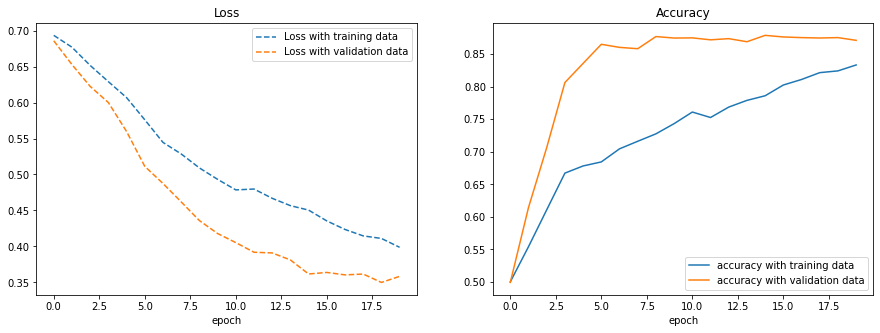

In [33]:
# visualizamos resultados:

history_dict = results4.history  # <-- extrae en 'accuracy' y 'loss' de cada 'epoch'
# history_dict = {'loss':[...], 'accuracy':[...], 'val_loss':[...], 'val_accuracy':[...] }

# Extraemos los valores de 'loss' y 'accuracy' obtenido en cada 'epoch':

loss_values_data_train = history_dict['loss']# <-- valores del 'loss' con datos de entrenamiento
loss_values_data_valid = history_dict['val_loss'] #<--valores del 'loss' con datos de validación
accuracy_values_data_train = history_dict['accuracy']# <-- valores del 'accuracy' con datos de entrenamiento
accuracy_values_data_valid = history_dict['val_accuracy'] # <-- valores del 'accuracy' con datos de validación

# numeramos 'epochs' contando desde 1:
epoch = range(n_epochs)

plt.figure()
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(epoch, loss_values_data_train, '--', label='Loss with training data')
plt.plot(epoch, loss_values_data_valid, '--', label='Loss with validation data')
plt.legend()
plt.title('Loss')
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy_values_data_train, label='accuracy with training data')
plt.plot(epoch, accuracy_values_data_valid, label='accuracy with validation data')
plt.legend()
plt.title('Accuracy')
plt.xlabel('epoch')

plt.show()

### En la grafica anterior se puede observar que hemos eliminado completamente el overfitting:
### 'Loss' pequeño con los datos de entrenamiento y 'Loss' pequeño con los datos de validación

In [34]:
# medimos precisión del entrenamiento con los datos de prueba:
model4.evaluate(x_test,y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.3672 - accuracy: 0.8678


[0.3672499656677246, 0.8677999973297119]

## Hacemos predicciones con el ultimo modelo entrenado:

In [35]:
# Predecimos las etiquetas de todos los features de prueba: 
y_predict = model4.predict(x_test)

y_predict.shape

(25000, 1)

In [36]:
# Predecimos una etiqueta en particular:

i = 478 #<--- indice del valor a predecir (< 25000)

label_obs  = labels_test[i] #np.argmax(y_test[i])
label_aprx = np.round( y_predict[i] )#np.argmax(y_predict[i])

print('    Etiqueta real: ', label_obs )
print('Etiqueta predicha: ', label_aprx )

    Etiqueta real:  1
Etiqueta predicha:  [1.]
